In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from gpmdm import GPMDM
from dataset_utils.mocap_labels import WALK_TRIALS_TRAIN, WALK_TRIALS_TEST, RUN_TRIALS_TRAIN, RUN_TRIALS_TEST
import dataset_utils.select_joints as select_joints

In [ ]:
gpdm_save_name = "gpmdm"

In [17]:
reduced_columns = WALK_TRIALS_TRAIN[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")


Number of DOFs: 35


In [18]:
walk_train_dfs = [trial.as_dataframe() for trial in WALK_TRIALS_TRAIN]
walk_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in walk_train_dfs]

run_train_dfs = [trial.as_dataframe() for trial in RUN_TRIALS_TRAIN]
run_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in run_train_dfs]


In [19]:
d = 3 # latent space dimension
DOFs = len(reduced_columns)  # number of degrees of freedom

dyn_back_step = 1 # Number of time steps to look back in the dynamics GP

# Initial values for hyperparameters
y_lambdas_init = np.ones(DOFs)  # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)  # Lengthscales for observation GP
y_sigma_n_init = 1e-2  # Noise standard deviation for observation GP

x_lambdas_init = np.ones(d)  # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(dyn_back_step*d)  # Lengthscales for latent dynamics GP
x_sigma_n_init = 1e-2  # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(dyn_back_step*d + 1)  # Linear coefficients for latent dynamics GP


In [ ]:
gpdm = GPMDM(
        D=DOFs,
        d=d,
        n_classes=2,
        dyn_target='full',
        dyn_back_step=dyn_back_step,
        y_lambdas_init=y_lambdas_init,
        y_lengthscales_init=y_lengthscales_init,
        y_sigma_n_init=y_sigma_n_init,
        x_lambdas_init=x_lambdas_init,
        x_lengthscales_init=x_lengthscales_init,
        x_sigma_n_init=x_sigma_n_init,
        x_lin_coeff_init=x_lin_coeff_init
    )

In [21]:
for train_arr in walk_train_arrs[0:6]:
    gpdm.add_data(train_arr, 0)
for train_arr in run_train_arrs[0:6]:
    gpdm.add_data(train_arr, 1)

total_sequences = sum([len(L) for L in gpdm.class_aware_observations_list])
print(f"Total sequences: {total_sequences}")

Total sequences: 12



### Model Training (Adam) ###

GPDM Opt. EPOCH: 0
Running loss: 7.2132e+07
Update time: 0.5177440643310547

GPDM Opt. EPOCH: 10
Running loss: 4.4176e+06
Update time: 5.896100044250488

GPDM Opt. EPOCH: 20
Running loss: 2.1262e+06
Update time: 4.292370319366455

GPDM Opt. EPOCH: 30
Running loss: 1.2242e+06
Update time: 5.6356201171875

GPDM Opt. EPOCH: 40
Running loss: 8.5667e+05
Update time: 4.145335912704468

GPDM Opt. EPOCH: 50
Running loss: 6.7100e+05
Update time: 3.5766079425811768

GPDM Opt. EPOCH: 60
Running loss: 5.5716e+05
Update time: 3.8669161796569824

GPDM Opt. EPOCH: 70
Running loss: 4.9177e+05
Update time: 4.170705318450928

GPDM Opt. EPOCH: 80
Running loss: 4.4885e+05
Update time: 4.1275835037231445

GPDM Opt. EPOCH: 90
Running loss: 4.1532e+05
Update time: 4.540014266967773

GPDM Opt. EPOCH: 100
Running loss: 3.8644e+05
Update time: 3.629258871078491

GPDM Opt. EPOCH: 110
Running loss: 3.6059e+05
Update time: 3.68816876411438

GPDM Opt. EPOCH: 120
Running loss: 3.3722e

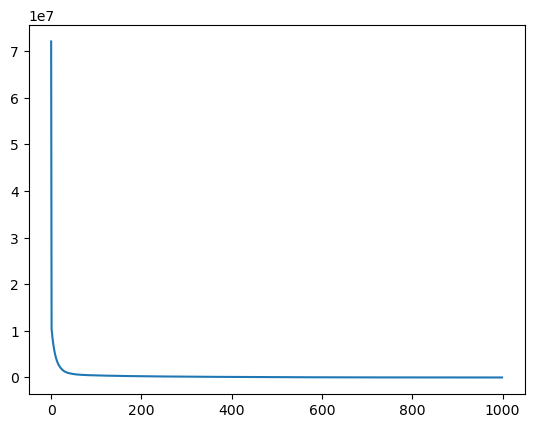

In [22]:
gpdm.init_X()  
losses = gpdm.train_adam(num_opt_steps=1000, num_print_steps=10, lr=0.05)

gpdm.save(f'{gpdm_save_name}_config.pth', f'{gpdm_save_name}_state.pth')  

plt.plot(losses)

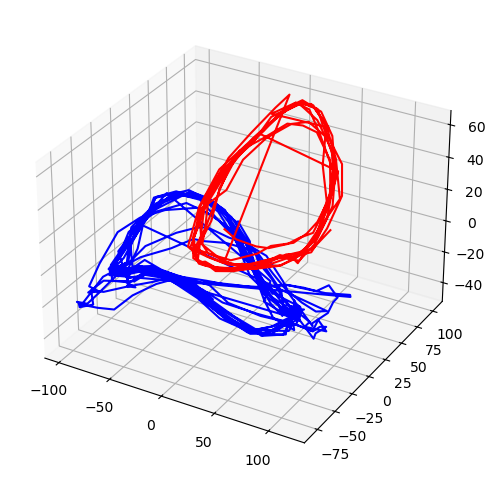

In [23]:
# Plot the latent space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()

# plot X0 in blue and X1 in red
ax.plot(X0[:, 0], X0[:, 1], X0[:, 2], 'b')
ax.plot(X1[:, 0], X1[:, 1], X1[:, 2], 'r')

plt.show()